In [1]:
###### https://www.kaggle.com/code/verracodeguacas/hoarders-ensemble

In [2]:
import os
import gc
import sys
import numpy as np
import pandas as pd 
# pd.set_option("display.max_columns", 50)
# pd.set_option("display.max_rows", 50)

from warnings import filterwarnings
filterwarnings(action="ignore", category=pd.errors.PerformanceWarning)
# pd.options.mode.chained_assignment = None # pd 경고문을 안 뜨게 해

# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

import joblib
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit

import json
import optuna
from itertools import combinations
# from pprint import pprint, pformat
# from optuna.visualization import (plot_optimization_history,
#                                  plot_param_importances,
#                                  plot_parallel_coordinate)

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
PATH = "/kaggle/input/optiver-trading-at-the-close/"
median_vol = pd.read_csv("/kaggle/input/optiver-memoryreduceddatasets/MedianVolV2.csv")
median_vol.index.name = "stock_id"
median_vol = median_vol[["overall_medvol","first5min_medvol","last5min_medvol"]]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
change_dtypes = {"stock_id": np.uint8,
                "date_id": np.uint16, 
                "seconds_in_bucket": np.uint16,
                "imbalance_buy_sell_flag": np.int8,
                "time_id": np.uint16}

train_df = pd.read_csv(PATH + "train.csv", dtype=change_dtypes).drop(columns=["row_id","time_id"], axis=1)
# test_df = pd.read_csv(PATH + "example_test_files/test.csv", dtype=change_dtypes).drop(columns=["row_id","time_id"], axis=1)

train_df.dropna(subset=["target"], inplace=True)
train_df.reset_index(drop=True, inplace=True)

del change_dtypes

In [4]:
train_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849


In [5]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print(f"starting memory: {start_mem}")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        # check if the column's data type is not "object" (i.e. numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                    
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                    
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
                else:
                    # check if the column's data type is a float
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float32)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float32)
                        
        if verbose:
            print(f"start memory: {start_mem}")
            end_mem = df.memory_usage().sum() / 1024 ** 2
            print(f"current memory: {end_mem}")
        
        return df

In [6]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a,b,c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val

            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)
            
    return imbalance_features


def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a,b,c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a,b,c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

In [ ]:
# https://www.kaggle.com/code/chengmoshun/macd-optiver
def fnMACD(df, column, m_num_fast=12, m_num_slow=26, m_num_signal=9):
    df["EMAFast"] = df[column].ewm(span=m_num_fast, min_periods=m_num_fast-1).mean()
    df["EMASlow"] = df[column].ewm(span=m_num_slow, min_periods=m_num_slow-1).mean()
    
    df[f"MACD_{column}"] = df["EMAFast"] - df["EMASlow"]
    df[f"MACDSignal_{column}"] = df[f"MACD_{column}"].ewm(span=m_num_signal,
                                                         min_periods=m_num_signal-1).mean()
    df[f"MACDDiff_{column}"] = df[f"MACD_{column}"] - df[f"MACDSignal_{column}"]
    del df["EMAFast"]
    del df["EMASlow"]
    return df


def get_moving_average(df, column):
    df[f"ma5_{column}"] = df[column].rolling(window=5).mean()
    df[f"ma15_{column}"] = df[column].rolling(window=15).mean()
    df[f"ma30_{column}"] = df[column].rolling(window=30).mean()
    df[f"ma60_{column}"] = df[column].rolling(window=60).mean()
    return df



def get_momentum(df, column, period=9):
    df[f"momentum10_{column}"] = df[column].pct_change(5)
    df[f"ma{period}_momentum10_{column}"] = df[f"momentum10_{column}"].rolling(window=period).mean()
    return df

def get_rsi(df, column, period=14):
    delta = df[column].diff()
    period = 14
    
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df["rsi"] = rsi
    return df

In [7]:
def create_features(df, reduce_memory=True):
#     cols_to_drop = ["imbalance_buy_sell_flag"]
    prices = ["reference_price","far_price","near_price","ask_price","bid_price","wap"]
    sizes = ["matched_size","bid_size","ask_size","imbalance_size"]
    
    df["volume"] = df.eval("ask_size + bid_size")
#     df["mid_price"] = df.eval("(ask_price + bid_size) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size - ask_size)/(bid_size + ask_size)")
#     df["matched_imbalance"] = df.eval("(imbalance_size - matched_size)/(matched_size + imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    df["price_spread"] = df.eval("ask_price - bid_price")
    df["imbalance_ratio"] = df.eval("imbalance_size / matched_size")
    
    df["ask_volume"] = df.eval("ask_size * ask_price")
    df["bid_volume"] = df.eval("bid_size * bid_price")
    
    df["ask_bid_volumes_diff"] = df["ask_volume"] - df["bid_volume"]
    
    df["bid_size_over_ask_size"] = df["bid_size"].div(df["ask_size"]) # size imbalance
    df["bid_price_over_ask_price"] = df["bid_price"].div(df["ask_price"])
    
    df["imbalance_buy_flag"] = np.where(df["imbalance_buy_sell_flag"]==1, True, False)
    df["imbalance_sell_flag"] = np.where(df["imbalance_buy_sell_flag"]==-1, True, False)
    
    # create features for pairwise price imbalances
    # https://www.kaggle.com/code/judith007/lb-5-3393-rapids-gpu-speeds-up-feature-engineer
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")
    
    # V2 features # 아래 피쳐들 의미를 잘 모르겠땅
    df["imbalance_momentum"] = df.groupby(["stock_id"])["imbalance_size"].diff(periods=1)/df["matched_size"]    
    df["spread_intensity"] = df.groupby(["stock_id"])["price_spread"].diff()
    df["price_pressure"] = df["imbalance_size"] * (df["ask_price"] - df["bid_price"])
    df["market_urgency"] = df["price_spread"] * df["liquidity_imbalance"]
    df["depth_pressure"] = (df["ask_size"] - df["bid_size"]) * (df["far_price"] - df["near_price"])
    
    # V3 features
    for col in ["matched_size","imbalance_size","reference_price","imbalance_buy_sell_flag"]:
        for window in [1,2,3,10]:      # 이거 숫자들의 의미가 뭐지?
            df[f"{col}_shift_{window}"] = df.groupby("stock_id")[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby("stock_id")[col].pct_change(window)
            
    # calculate diff features for specific columns
    for col in ["ask_price","bid_price","ask_size","bid_size"]:
        for window in [1,2,3,10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
            
    for c in [["ask_price","bid_price","wap","reference_price"], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    
#     df = df.drop(columns=cols_to_drop)
    
    if reduce_memory:
        print(f"Reducing memory usage... (Current: {df.memory_usage().sum() / 1024 / 1024:.1f} MB)")
        df = df.astype({"stock_id":"uint8",
                       "seconds_in_bucket":"uint16",
                       # converts all float64s to float32s
                       **{col:"float32" for col in df.columns if df[col].dtype == "float64"}})
        print(f"Memory usage after reduction: {df.memory_usage().sum() / 1024 / 1024:.1f} MB")
    
    return df

In [8]:
from IPython.display import FileLink
train_df = create_features(train_df)
train_df = reduce_mem_usage(train_df)
train_df = train_df.merge(median_vol, how="left", left_on="stock_id", right_index=True)
date_ids = train_df["date_id"].values
del median_vol
print(train_df.shape)
#     os.chdir("/kaggle/working/")
#     FileLink("train.feather")

y = train_df["target"]
train_df.drop(columns=["date_id","stock_id"], inplace=True)

feat_importances = ["seconds_in_bucket","market_urgency","near_price_ask_price_imb",\
"reference_price_wap_imb","wap","far_price_bid_price_imb","reference_price_bid_price_imb",\
"ask_price_diff_2","imbalance_size_shift_1","far_price_near_price_imb",\
"matched_size_ask_size_imbalance_size_imb2",\
"matched_size_ret_10","price_spread","matched_size_shift_10","bid_price_diff_1","spread_intensity",\
"ask_price_bid_price_reference_price_imb2","reference_price_ask_price_imb",\
"matched_size_bid_size_imbalance_size_imb2",
"reference_price_ret_3","far_price_ask_price_imb",\
                    "imbalance_momentum","bid_price","ask_price",\
"ask_price_diff_1","imbalance_ratio","imbalance_buy_sell_flag",\
                    "reference_price_ret_10",\
                    
"reference_price","volume","bid_size_ask_size_imbalance_size_imb2","imbalance_size",\
"bid_volume","matched_size_shift_1","matched_size_bid_size_ask_size_imb2",\
                    
"bid_price_over_ask_price","bid_price_wap_imb","reference_price_shift_3",\
"reference_price_ret_1","bid_size_diff_1","reference_price_shift_1",\
                    "ask_size","bid_price_diff_10",\
"matched_size_ret_1","matched_size_shift_2","matched_size_shift_3",\
                    "ask_price_diff_10",\
"ask_size_diff_1","ask_volume","ask_price_bid_price_wap_imb2",\
                    "reference_price_ret_2","reference_price_shift_2",\
"matched_size_ret_3","bid_size_diff_3","matched_size_ret_2",\
                    "price_pressure","bid_size_diff_2",\
"ask_size_diff_3","reference_price_far_price_imb",\
                    "liquidity_imbalance","bid_price_wap_reference_price_imb2",\
"bid_size_diff_10","ask_size_diff_10",\
                "bid_size_over_ask_size","ask_bid_volumes_diff",\
"depth_pressure","overall_medvol","target"]

train_df = train_df[feat_importances]
# train_df.head()

/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'comb_indices' of function 'compute_triplet_imbalance'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../tmp/ipykernel_32/3417327308.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'comb__indices' of function '__numba_parfor_gufunc_0x79887cc9e620'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<string>", lin

Reducing memory usage... (Current: 3916.3 MB)
Memory usage after reduction: 1978.1 MB
starting memory: 1978.1163787841797
(5237892, 106)


<Axes: >

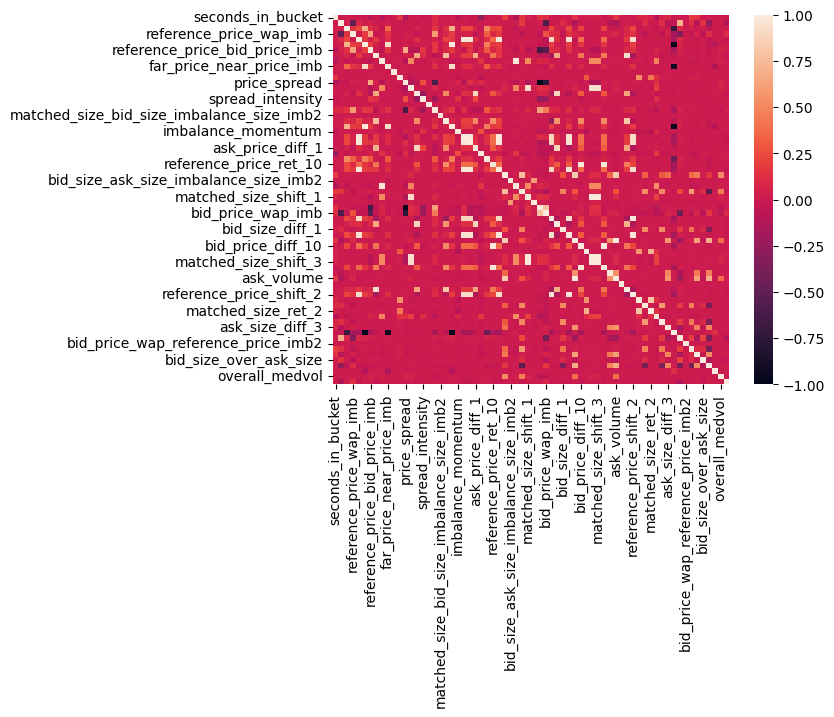

In [9]:
import seaborn as sns
sns.heatmap(np.around(train_df.corr(), 2)) #, annot=True)

In [10]:
# IR: Information Ratio     as a feature..넣어주긔 
def calculate_information_ratio(x1, x2):
    assert len(x1) == len(x2)
    interval = 495000  # 45 days

In [11]:
for_drops = []
for col,d in zip(train_df.columns, train_df.isnull().sum()):
#     print(col, " :: ", d)
    if (d/5237892) > 0.5:
        for_drops.append(col)

In [12]:
train_df.drop(columns=for_drops, inplace=True)
# print(train_df.shape)
gc.collect()

24197

In [13]:
def cross_validate(model, X, y, cv):
    scores = np.zeros(cv.n_splits)
    
    print(f"Starting evaluation..")
    print("="*30)
    for i, (train_index, test_index) in enumerate(cv.split(X)):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False, test_size=0.1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(25, verbose=False)])
        
        y_pred = model.predict(X_test)
        scores[i] = mean_absolute_error(y_pred, y_test)
        print(f"Fold {i+1}: {scores[i]:.4f}")
        
    print("-"*30)
    print(f"Average MAE = {scores.mean():.4f} ± {scores.std():.2f}")
    print("="*30)
    
    return scores

In [14]:
### optimizing Optuna
def objective(trial):
    params = {"random_seed": 123,
             "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
             "num_leaves": trial.suggest_int("num_leaves", 20, 100),
             "max_depth": trial.suggest_int("max_depth", 1, 12),
             "min_child_samples": trial.suggest_int("min_child_samples", 20, 100),
             "subsample": trial.suggest_float("subsample", 0.4, 1.0),
             "subsample_freq": trial.suggest_categorical("subsample_freq", [0,1]),
             "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
             "reg_lambda": trial.suggest_float("reg_lambda", 5e-1, 1.0, log=True)}
#               "learning_rate": trial.suggest_float("learning_rate", 0.07, 0.12, log=False),
#               "num_leaves": num_leaves}
    
    model = lgb.LGBMRegressor(**params)
    model.fit(train_df, y)
    y_pred = model.predict(train_df)
    score = mean_absolute_error(y, y_pred)
    return score

In [15]:
def run_optimization(objective, n_trials=100, n_jobs=1, best_trial=None):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="minimize")
    
    if best_trial is not None:
        print("Enqueuing previous best trial...")
        study.enqueue_trial(best_trial)
    
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs, show_progress_bar=True)
    print(study.best_params)
    
    print(f"Num of finished trials: {len(study.trials)}")
    print(f"Best MAE: {study.best_value:.4f}")
    
    print("Params")
    print("=" * 10)
    print(study.best_params)
    with open("/kaggle/working/best_params.json", "w") as f:
        json.dump(study.best_params, f)
        os.chdir("/kaggle/working/")
        FileLink("best_params.json")
    return study

In [16]:
LOGGING_LEVELS = ["DEBUG","ㅇWARNING","INFO","SUCCESS","WARNING"]
def get_objective_function(cv=None, logging_level="info"):
    """Returns the objective function for optuna."""
    # configure logging level
    if logging_level.upper() not in LOGGING_LEVELS:
        raise ValueError(f"Expected logging_level to be one of {LOGGING_LEVELS}, but got '{logging_level}' instead.")
    handler = {"sink": sys.stdout, "level": logging_level.upper()}
        
    def optimize_lgbm(trial):
        """Optimizes a LGBMRegressor with cross-validation."""
        max_depth = 18
        param_space = {"boosting_type":"gbdt",
            "objective": "mae",
            "subsample": 0.6,
#             "num_leaves": 300, #30,
            "n_estimators": 8000, # 700,
            "min_child_samples": 20,
#             "reg_alpha": 0.02,
#             "reg_lambda": 0.01,
            "learning_rate": 0.087,
            "num_leaves": trial.suggest_int("num_leaves", 20, int((2**max_depth) * 0.75)),
            "max_depth": max_depth
        }
        model = lgb.LGBMRegressor(**param_space)    
        scores = cross_validate(model, train_df, y, cv=cv)
        return scores.mean()
    return optimize_lgbm

In [17]:
lgb_params2 = {'objective': 'mae',
 'n_estimators': 5500,
 'num_leaves': 128,
 'subsample': 0.6,
 'colsample_bytree': 0.8,
 'learning_rate': 5e-05,
 'max_depth': 11,
 'n_jobs': 4,
 'device': 'gpu',
 'verbosity': -1,
 'importance_type': 'gain'}

In [ ]:
# run_lgbm_optimization = False
# n_trials = 5
# logging_level = "info"
# cv = TimeSeriesSplit(n_splits=3)  # 5

# reuse_best_trial = False
# best_trial = lgb_params

# import pickle
# from IPython.display import clear_output
# if run_lgbm_optimization:
#     clear_output(wait=True)
#     objective = get_objective_function(cv=cv, logging_level=logging_level)
#     study = run_optimization(objective, n_trials=n_trials, n_jobs=1, 
#                             best_trial=best_trial)
#     lgbm_best_params = study.best_params if reuse_best_trial else None
#     print("best params:", study.best_params)
    
# model_save_path = "/kaggle/working/models/"
models = []
scores = []
    
# rng = np.random.default_rng()
# seeds = rng.integers(low=0, high=1000, size=3)
# for i, seed in enumerate(seeds):
#     print(f"Fitting model {i} with seed={seed}")
#     X_train, X_test, y_train, y_test = train_test_split(train_df, y, shuffle=False, test_size=0.2)
#     model = lgb.LGBMRegressor(**lgbm_best_params)
#     model.set_params(random_state=seed)

#     callbacks = [
#         lgb.log_evaluation(period=100),
#         lgb.early_stopping(100, verbose=True)
#     ]
#     model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=callbacks)
#     mean_absolute_error(y_test, model.predict(X_test, num_iteration=model.best_iteration_))
#     save_model(model, name=f"model-{i}")

num_folds = 5
fold_size = 480 // num_folds
feature_name = [i for i in train_df.columns if i not in ["row_id", "target", "time_id", "date_id"]]
y = train_df["target"]
train_df.drop(columns=["target"], inplace=True)
for i in range(num_folds):
    start = i * fold_size
    end = start + fold_size
    
    # Define the purged set ranges
    purged_before_start = start - 2
    purged_before_end = start + 2
    purged_after_start = end - 2
    purged_after_end = end + 2
    
    # Exclude the purged ranges from the test set
    purged_set = ((date_ids >= purged_before_start) & (date_ids <= purged_before_end)) | \
                 ((date_ids >= purged_after_start) & (date_ids <= purged_after_end))
    
    # Define test_indices excluding the purged set
    test_indices = (date_ids >= start) & (date_ids < end) & ~purged_set
    train_indices = ~test_indices & ~purged_set
    
    df_fold_train = train_df[train_indices]
    df_fold_train_target = y[train_indices]
    df_fold_valid = train_df[test_indices]
    df_fold_valid_target = y[test_indices]
#     train_df.drop(["target"], axis=1, inplace=True)

    print(f"Fold {i+1} Model Training")
    
    # Train a LightGBM model for the current fold
    lgb_model = lgb.LGBMRegressor(**lgb_params2)
    lgb_model.fit(
        df_fold_train[train_df.columns],
        df_fold_train_target,
        eval_set=[(df_fold_valid[train_df.columns], 
                   df_fold_valid_target)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
        ],
    )

    # Append the model to the list
    models.append(lgb_model)
    # Save the model to a file
#     model_filename = os.path.join(model_save_path, f'doblez_{i+1}.txt')
#     lgb_model.booster_.save_model(model_filename)
#     print(f"Model for fold {i+1} saved to {model_filename}")

    # Evaluate model performance on the validation set
    fold_predictions = lgb_model.predict(df_fold_valid[feature_name])
    fold_score = mean_absolute_error(fold_predictions, df_fold_valid_target)
    scores.append(fold_score)
    print(f"Fold {i+1} MAE: {fold_score}")

    # Free up memory by deleting fold specific variables
    del df_fold_train, df_fold_train_target, df_fold_valid, df_fold_valid_target
    gc.collect()

Fold 1 Model Training
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 5.71993
[200]	valid_0's l1: 5.71875
[300]	valid_0's l1: 5.71758
[400]	valid_0's l1: 5.71642
[500]	valid_0's l1: 5.71527
[600]	valid_0's l1: 5.71413
[700]	valid_0's l1: 5.713
[800]	valid_0's l1: 5.71189
[900]	valid_0's l1: 5.71079
[1000]	valid_0's l1: 5.70969
[1100]	valid_0's l1: 5.70861
[1200]	valid_0's l1: 5.70753
[1300]	valid_0's l1: 5.70647
[1400]	valid_0's l1: 5.70541
[1500]	valid_0's l1: 5.70436
[1600]	valid_0's l1: 5.70332
[1700]	valid_0's l1: 5.70229
[1800]	valid_0's l1: 5.70127
[1900]	valid_0's l1: 5.70026
[2000]	valid_0's l1: 5.69927
[2100]	valid_0's l1: 5.69828
[2200]	valid_0's l1: 5.6973
[2300]	valid_0's l1: 5.69632
[2400]	valid_0's l1: 5.69536
[2500]	valid_0's l1: 5.6944
[2600]	valid_0's l1: 5.69345
[2700]	valid_0's l1: 5.69251
[2800]	valid_0's l1: 5.69158
[2900]	valid_0's l1: 5.69065
[3000]	valid_0's l1: 5.68974
[3100]	valid_0's l1: 5.68883
[3200]	valid_0's l1: 5.68793
[

In [ ]:
import optiver2023
iter_test = env.iter_test()

lgb_model.fit(train_df, y)

In [ ]:
cnt = 0
for (test, revealed_targets, sample_predict) in iter_test:
    sample_predict["target"] = lgbmodel.predict(test.drop("row_id", axis=1))
    env.predict(sample_predict)
    cnt += 1